In [6]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [8]:
# Load data
data = pd.read_csv("data/processed_data_full.csv")

# Extract columns
file_names = data.iloc[:, 0]  # First column: file names
features = data.iloc[:, 1:26].values  # Middle columns: features
labels = data.iloc[:, -1].values  # Last column: labels

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Encode labels into numbers

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=42, stratify=encoded_labels)

# Normalize features (after splitting to avoid data leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Define grid search parameters
n_components_range = [1,2,3,4]  # Number of hidden states
hmm_types = ['GMMHMM', 'GaussianHMM'] 
covariance_types = ['full', 'diag', 'spherical']  # Covariance types (only for Gaussian and GMM HMMs)
n_iter = 100  # Fixed number of iterations

# Initialize variables to store the best model and accuracies
best_accuracy = 0
best_params = {}
results = []

# Define function for predicting language
def predict_language(models, test_features):
    max_log_likelihood = float('-inf')
    predicted_language = None
    for lang, model in models.items():
        try:
            log_likelihood = model.score(test_features)
            if log_likelihood > max_log_likelihood:
                max_log_likelihood = log_likelihood
                predicted_language = lang
        except:
            pass  # Handle any scoring errors gracefully
    return predicted_language

# Perform grid search
print("Starting Grid Search...\n")
for hmm_type in hmm_types:
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            print(f"Training models with: hmm_type={hmm_type}, "
                  f"n_components={n_components}, covariance_type={covariance_type}")
            
            # Initialize models dictionary for current configuration
            models = {}
            progress = 0
            
            # Train HMM models for each language
            for lang in np.unique(y_train):
                # Get features corresponding to the current language
                lang_features = X_train[y_train == lang]

                # Create HMM model
                if hmm_type == 'GMMHMM':
                    model = hmm.GMMHMM(n_components=n_components, 
                                            covariance_type=covariance_type, 
                                            n_iter=n_iter, 
                                            random_state=42)
                    
                elif hmm_type == 'GaussianHMM':
                    model = hmm.GaussianHMM(n_components=n_components, 
                                               covariance_type=covariance_type, 
                                               n_iter=n_iter, 
                                               random_state=42)
                
                elif hmm_type == 'MultinomialHMM':
                    model = hmm.MultinomialHMM(n_components=n_components, 
                                               n_iter=n_iter, 
                                               random_state=42)
                elif hmm_type == 'PoissonHMM':
                    model = hmm.PoissonHMM(n_components=n_components, 
                                           n_iter=n_iter, 
                                           random_state=42)
                
                # Train the model
                model.fit(lang_features)
                models[lang] = model
                progress += 1
                print(f"  Progress: {progress}/{len(np.unique(y_train))} models trained.")
            
            # Evaluate on test data
            correct = 0
            for i in range(len(X_test)):
                predicted_lang = predict_language(models, [X_test[i]])
                if predicted_lang == y_test[i]:
                    correct += 1

            accuracy = correct / len(X_test)
            print(f"  Model Accuracy: {accuracy * 100:.2f}%\n")
            
            # Store results
            results.append({
                'hmm_type': hmm_type,
                'n_components': n_components,
                'covariance_type': covariance_type,
                'accuracy': accuracy
            })
            
            # Update best model if current is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'hmm_type': hmm_type,
                    'n_components': n_components,
                    'covariance_type': covariance_type
                }

# Display final results
print("\nGrid Search Completed!")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")

# Convert results to DataFrame and display as a table
results_df = pd.DataFrame(results)
print("\nGrid Search Results:")
print(results_df)

Starting Grid Search...

Training models with: hmm_type=GMMHMM, n_components=1, covariance_type=full
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 94.99%

Training models with: hmm_type=GMMHMM, n_components=1, covariance_type=diag
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 78.78%

Training models with: hmm_type=GMMHMM, n_components=1, covariance_type=spherical
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 mo

Model is not converging.  Current: -428918.4962471294 is not greater than -428918.4959545477. Delta is -0.0002925816806964576


  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 64.04%

Training models with: hmm_type=GMMHMM, n_components=3, covariance_type=full
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 55.70%

Training models with: hmm_type=GMMHMM, n_components=3, covariance_type=diag
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 66.23%

Training models with: hmm_type=GMMHMM, n_components=3, covariance_

Model is not converging.  Current: -96841.62015483371 is not greater than -96841.61699809018. Delta is -0.0031567435362376273


  Progress: 8/8 models trained.
  Model Accuracy: 57.08%

Training models with: hmm_type=GaussianHMM, n_components=1, covariance_type=full
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 94.99%

Training models with: hmm_type=GaussianHMM, n_components=1, covariance_type=diag
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  Progress: 5/8 models trained.
  Progress: 6/8 models trained.
  Progress: 7/8 models trained.
  Progress: 8/8 models trained.
  Model Accuracy: 78.78%

Training models with: hmm_type=GaussianHMM, n_components=1, covariance_type=spherical
  Progress: 1/8 models trained.
  Progress: 2/8 models trained.
  Progress: 3/8 models trained.
  Progress: 4/8 models trained.
  

In [11]:
class GaussianHMM_Collective:
    def __init__(self, n_components=1, covariance_type='full', n_iter=100):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.n_iter = n_iter
        self.models = {}
    
    def fit(self, X, y):
        for lang in np.unique(y):
            lang_features = X[y == lang]
            model = hmm.GaussianHMM(n_components=self.n_components, 
                                covariance_type=self.covariance_type, 
                                n_iter=self.n_iter, 
                                random_state=42)
            model.fit(lang_features)
            self.models[lang] = model
    
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            max_log_likelihood = float('-inf')
            predicted_language = None
            for lang, model in self.models.items():
                try:
                    log_likelihood = model.score([X[i]])
                    if log_likelihood > max_log_likelihood:
                        max_log_likelihood = log_likelihood
                        predicted_language = lang
                except:
                    pass
            predictions.append(predicted_language)
        return predictions


In [12]:
gaussian_hmm = GaussianHMM_Collective(n_components=1, covariance_type='full', n_iter=100)
gaussian_hmm.fit(X_train, y_train)

Accuracy: 94.99%

Classification Report:
              precision    recall  f1-score   support

     Bengali       0.97      0.95      0.96      8164
    Gujarati       0.93      0.94      0.94      7868
       Hindi       0.97      0.99      0.98      7636
     Kannada       0.98      0.89      0.93      6488
   Malayalam       0.90      0.98      0.94      7200
     Marathi       0.97      0.91      0.94      7427
       Tamil       0.95      0.98      0.96      7258
      Telugu       0.89      0.97      0.93      1665

    accuracy                           0.95     53706
   macro avg       0.94      0.95      0.95     53706
weighted avg       0.95      0.95      0.95     53706



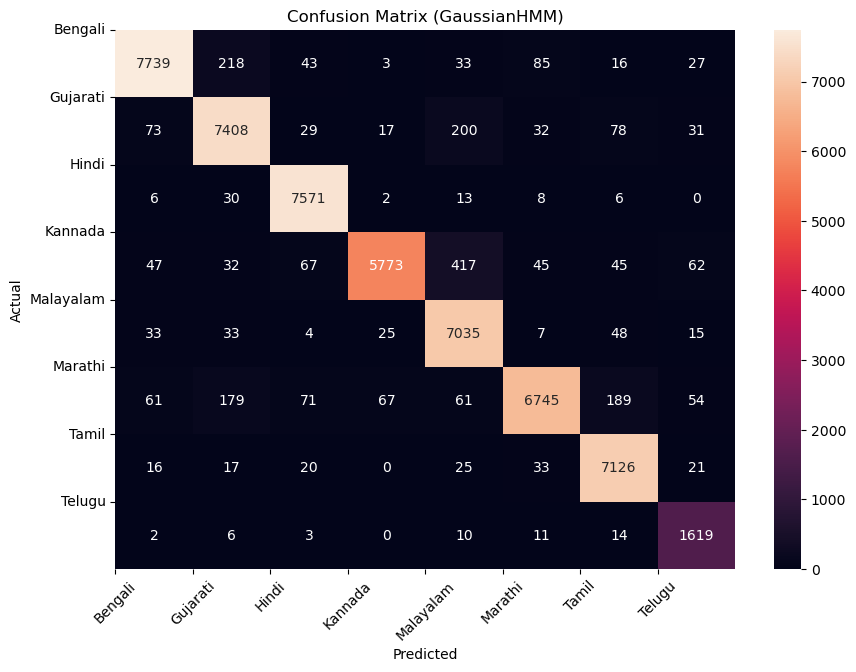

In [13]:
y_pred = gaussian_hmm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GaussianHMM)')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=0)
plt.show()


In [14]:
with open('models/gaussian_hmm.pkl', 'wb') as file:
    pickle.dump(gaussian_hmm, file)

In [15]:
train = pd.read_csv("data/data_train.csv")
test = pd.read_csv("data/data_test.csv")

X_train = train.drop('class', axis=1)
y_train = train['class']

X_test = test.drop('class', axis=1)
y_test = test['class']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train)
y_test = lbe.transform(y_test)

In [16]:
full_gaussian_hmm = GaussianHMM_Collective(n_components=1, covariance_type='full', n_iter=100)
full_gaussian_hmm.fit(X_train, y_train)

Accuracy: 96.24%

Classification Report:
              precision    recall  f1-score   support

     Bengali       0.97      0.97      0.97      8164
    Gujarati       0.98      0.95      0.97      7868
       Hindi       0.96      1.00      0.98      7636
     Kannada       0.97      0.91      0.94      6488
   Malayalam       0.94      0.97      0.95      7200
     Marathi       0.96      0.94      0.95      7427
       Tamil       0.97      0.99      0.98      7258
      Telugu       0.91      0.98      0.95      1665

    accuracy                           0.96     53706
   macro avg       0.96      0.96      0.96     53706
weighted avg       0.96      0.96      0.96     53706



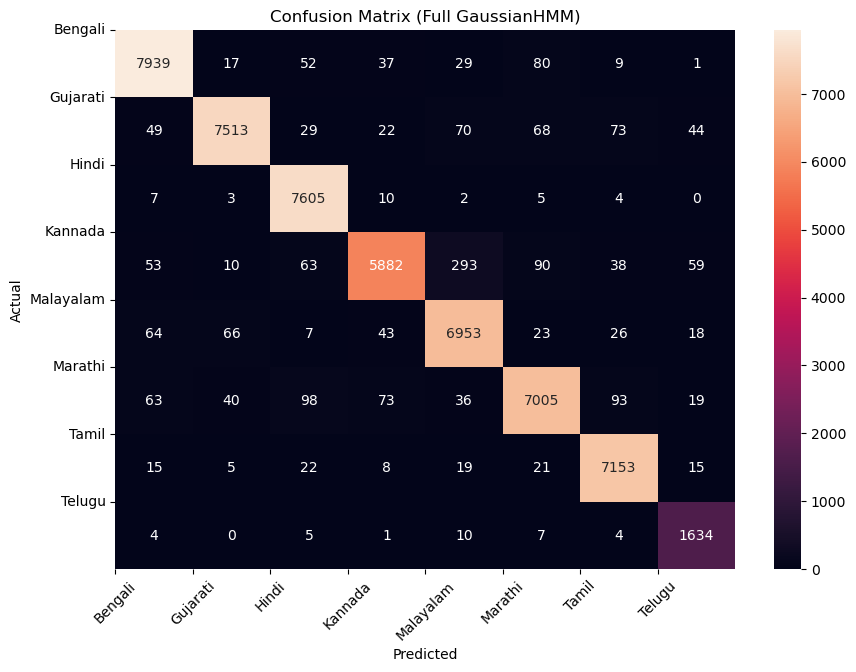

In [17]:
full_y_pred = full_gaussian_hmm.predict(X_test)
accuracy = accuracy_score(y_test, full_y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, full_y_pred, target_names=lbe.classes_))

# Display confusion matrix
cm = confusion_matrix(y_test, full_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Full GaussianHMM)')
plt.xticks(np.arange(len(lbe.classes_)), lbe.classes_, rotation=45)
plt.yticks(np.arange(len(lbe.classes_)), lbe.classes_, rotation=0)
plt.show()

In [18]:
with open('models/full_gaussian_hmm.pkl', 'wb') as file:
    pickle.dump(full_gaussian_hmm, file)